## Import Package and Load data from kaggle

In [1]:


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# Install kaggle if not already installed
!pip install kaggle

# Download the dataset (you'll need your Kaggle API credentials)
!kaggle datasets download -d stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset

# Unzip the downloaded dataset
!unzip rotten-tomatoes-movies-and-critic-reviews-dataset.zip




In [2]:
df = pd.read_csv("rotten_tomatoes_critic_reviews.csv")
df.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


## Data cleaning

In [3]:
# check for null values
df.isnull().sum()

,0
rotten_tomatoes_link,0
critic_name,18529
top_critic,0
publisher_name,0
review_type,0
review_score,305936
review_date,0
review_content,65806


In [4]:
df.shape

(1130017, 8)

<Axes: >

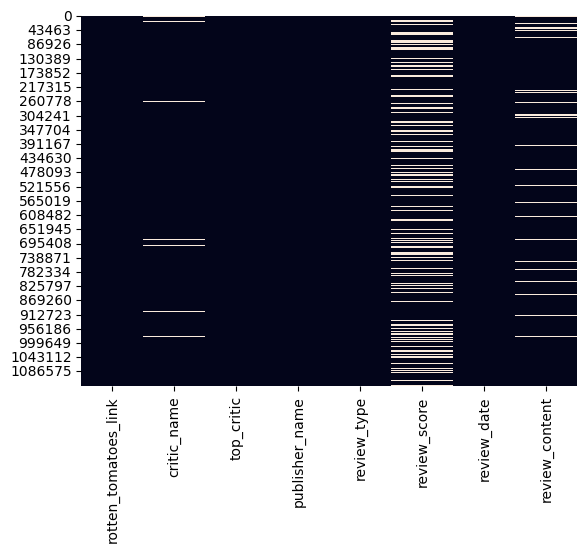

In [5]:
# view null values in heatmap using seaborn
import seaborn as sns
sns.heatmap(df.isnull(), cbar=False)

In [6]:
# drop null values in review_score column
df.dropna(subset=['review_score'], inplace=True)

<Axes: >

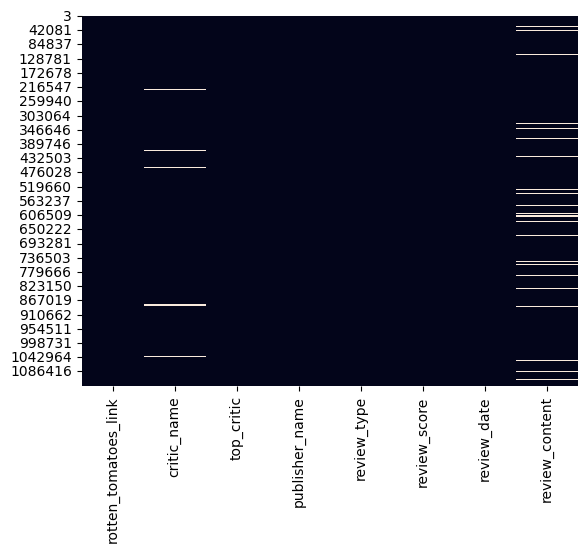

In [7]:
sns.heatmap(df.isnull(), cbar=False)

In [8]:
df.shape

(824081, 8)

In [9]:
# delete null values in review_content
df.dropna(subset=['review_content'], inplace=True)

In [10]:
df.shape

(758709, 8)

In [11]:
# see all the unique values in review_score
df['review_score'].unique()

array(['3.5/5', '1/4', 'B', '3/5', '4/5', '2/4', '2/5', 'C', '2.5/4',
       '3/4', 'C-', '2.75/5', 'B-', '2.5/5', '5.5/10', '1/5', 'C+', 'D+',
       '1.5/4', '6.5/10', '3/10', '1.5/5', '4/10', '7/10', '6/10', 'B+',
       '5/5', 'A-', '4.5/5', '5.78/10', '3.5/4', 'A', '9/10', '8.5/10',
       '4/4', '83/100', '8/10', '92/100', '82/100', '84/100', '10/10',
       'D-', 'F', '0.5/4', 'D', '5/10', '2/10', '2/6', '0.5/5', '0/4',
       '0/5', '76/100', '74/100', '86/100', '81/100', '56/100', '78/100',
       '2.25/5', '8.8/10', '0/10', '44/100', '2.75/4', '2.4/5', '8.6/10',
       '79/100', '80/100', '90/100', '66/100', '91/100', '0.3/5',
       '9.2/10', '2.7/5', '57/100', '4/6', '3/6', '73/100', '42/100',
       '65/100', '7.5/10', '4.5/10', '1/6', '70/100', '3.5/10', '71/100',
       '0.1/5', '3.25/10', '89/100', '40/100', '64/100', '62/100', '1/10',
       '3.75/5', '37/100', '5/6', '68/100', '60/100', '3.3/5', '77/100',
       '87/100', '5.25/10', '1.4/4', '75/100', '1.5/6', '85/100

### cleaning dependent variable

In [12]:
import re

In [13]:
# Define mapping for letter grades (adjust based on scale)
grade_mapping = {
    "A+": 5.0, "A": 4.5, "A-": 4.3,
    "B+": 4.0, "B": 3.5, "B-": 3.3,
    "C+": 3.0, "C": 2.5, "C-": 2.3,
    "D+": 2.0, "D": 1.5, "D-": 1.3,
    "F": 1.0
}

In [14]:
def clean_review_score(score):
    if isinstance(score, str):
        # Match "x/5" format
        match_5 = re.match(r'^(\d+(\.\d+)?)/5$', score)
        if match_5:
            return float(match_5.group(1))  # Extract number before "/5"

        # Match "x/10" format and scale it to /5
        match_10 = re.match(r'^(\d+(\.\d+)?)/10$', score)
        if match_10:
            return (float(match_10.group(1)) / 10) * 5  # Scale to 5-point rating

        match_100 = re.match(r'^(\d+(\.\d+)?)/100$', score)
        if match_100:
            return (float(match_100.group(1)) / 100) * 5  # Scale to 5-point rating

        # match_6 = re.match(r'^(\d+(\.\d+)?)/6$', score)
        # if match_6:
        #     return (float(match_6.group(1)) / 6) * 5  # Scale to 5-point rating

        match_2 = re.match(r'^(\d+(\.\d+)?)/2$', score)
        if match_2:
            return (float(match_2.group(1)) / 2) * 5  # Scale to 5-point rating

        # match_90 = re.match(r'^(\d+(\.\d+)?)/90$', score)
        # if match_90:
        #     return (float(match_90.group(1)) / 90) * 5

        # match_8 = re.match(r'^(\d+(\.\d+)?)/8$', score)
        # if match_8:
        #     return (float(match_8.group(1)) / 8) * 5

        # match_24 = re.match(r'^(\d+(\.\d+)?)/24$', score)
        # if match_24:
        #     return (float(match_24.group(1)) / 24) * 5

        # match_4 = re.match(r'^(\d+(\.\d+)?)/4$', score)
        # if match_4:
        #     return (float(match_4.group(1)) / 4) * 5

        # match_44 = re.match(r'^(\d+(\.\d+)?)/44$', score)
        # if match_44:
        #     return (float(match_44.group(1)) / 44) * 5

        # match_40 = re.match(r'^(\d+(\.\d+)?)/40$', score)
        # if match_40:
        #     return (float(match_40.group(1)) / 40) * 5

        # match_60 = re.match(r'^(\d+(\.\d+)?)/60$', score)
        # if match_60:
        #     return (float(match_60.group(1)) / 60) * 5

        # match_70 = re.match(r'^(\d+(\.\d+)?)/70$', score)
        # if match_70:
        #     return (float(match_70.group(1)) / 70) * 5

        # match_50 = re.match(r'^(\d+(\.\d+)?)/50$', score)
        # if match_50:
        #     return (float(match_50.group(1)) / 50) * 5

        # match_00 = re.match(r'^(\d+(\.\d+)?)/00$', score)
        # if match_00:
        #     return (float(match_00.group(1)) / 100) * 5

        # match_1000 = re.match(r'^(\d+(\.\d+)?)/1000$', score)
        # if match_1000:
        #     return (float(match_1000.group(1)) / 1000) * 5

        # match_20 = re.match(r'^(\d+(\.\d+)?)/20$', score)
        # if match_20:
        #     return (float(match_20.group(1)) / 20) * 5

        # match_1 = re.match(r'^(\d+(\.\d+)?)/1$', score)
        # if match_1:
        #     return (float(match_1.group(1)) / 1) * 5

        # match_3 = re.match(r'^(\d+(\.\d+)?)/3$', score)
        # if match_3:
        #     return (float(match_3.group(1)) / 3) * 5

        # match_13 = re.match(r'^(\d+(\.\d+)?)/13$', score)
        # if match_13:
        #     return (float(match_13.group(1)) / 13) * 5

        match_dec = re.match(r'^(\d+)$', score)
        if match_dec:
            return (float(match_dec.group(1)) / 100) * 5
        # Match letter grades
        if score in grade_mapping:
            return grade_mapping[score]

    return None
# Apply the function
df_y = df['review_score'].apply(clean_review_score)


In [15]:
df_y.count()

508500

In [16]:
df['review_score'] = df_y

In [17]:
# delete null values
df.dropna(subset=['review_score'], inplace=True)

### As There is not enough computational power (RAM) available for PCA dimension reduction and training, we will sample atmost amount of data for the training, I'm taking 20% here.

In [18]:
df = df.sample(frac=0.02, replace= True, random_state=42)

In [19]:
df.shape

(10170, 8)

In [20]:
# split the data into X and y
X = df['review_content']
y = df['review_score']

## vectorize the reviews content to numeric

In [21]:
vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(X)


## split data into train and test

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

## Dimension reduction is done for efficient training and less computation required.

In [23]:
from sklearn.decomposition import PCA, IncrementalPCA

In [24]:
ipca = IncrementalPCA(n_components=7)
X_train_pca = ipca.fit_transform(X_train)
X_test_pca = ipca.transform(X_test)

## Model Evaluation

In [25]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_pca, y_train)


RandomForestRegressor(random_state=42)

In [26]:
y_pred = model.predict(X_test_pca)

In [27]:
# model evaluation mse and r2
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"R2 square: {r2}")
print(f"Mean Squared Error: {mse:.4f}")

R2 square: 0.005150264383401271
Mean Squared Error: 0.9928


In [28]:
#Linear regression evaluation
LRModel = LinearRegression()
LRModel.fit(X_train_pca, y_train)

LinearRegression()

In [29]:
# mse and r2 evaluation
y_pred = LRModel.predict(X_test_pca)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"R2 square: {r2}")
print(f"Mean Squared Error: {mse:.4f}")

R2 square: 0.023848715711160096
Mean Squared Error: 0.9742


In [30]:

import xgboost as xgb


In [31]:
# xgboostregressor model training
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_model.fit(X_train_pca, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [32]:
# xgbregressor mse and r2 evaluation
y_pred = xgb_model.predict(X_test_pca)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"R2 square: {r2}")
print(f"Mean Squared Error: {mse:.4f}")

R2 square: -0.07770180606358035
Mean Squared Error: 1.0755


In [35]:
# example for predicting a new review using LRModel
new_review = ["This movie is good! not bad for a debut director."]
new_review_tfidf = vectorizer.transform(new_review)
new_review_pca = ipca.transform(new_review_tfidf)
predicted_score = LRModel.predict(new_review_pca)
print(f"Predicted Score: {predicted_score[0]:.2f}")

Predicted Score: 2.80


## Save the best Model

In [33]:
#save the LRmodel using pickle
import pickle
pickle.dump(LRModel, open('LRModel.pkl', 'wb'))
